In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
#check class
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [4]:
inputs = df['tweet']
labels = df['label']

In [5]:
inputs_train, inputs_test, ytrain, ytest = train_test_split(inputs, labels, random_state = 123)

### Logistic Regression

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [7]:
#remove the user name
stops = set(stopwords.words('english'))
stops = stops.union({'@user'})

In [8]:
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens if t not in stops]

In [9]:
vectorize = CountVectorizer(tokenizer=StemTokenizer(),lowercase = True, max_features= 2000)

Xtrain = vectorize.fit_transform(inputs_train)
Xtest = vectorize.transform(inputs_test)

model = LogisticRegression(max_iter=500)

model.fit(Xtrain, ytrain)
pred_train = model.predict(Xtrain)
pred_test = model.predict(Xtest)

print('Train acc:', accuracy_score(ytrain, pred_train))
print('Test acc:', accuracy_score(ytest, pred_test))

Train acc: 0.963831296149514
Test acc: 0.9544487548492053


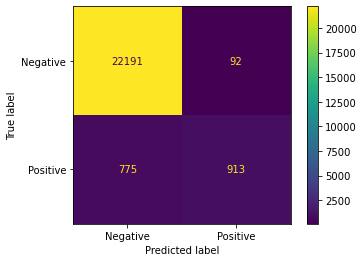

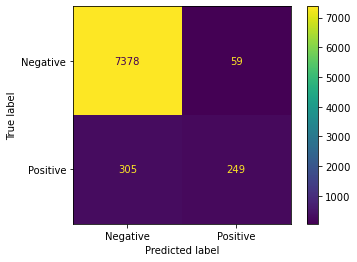

In [10]:
cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = ['Negative','Positive'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['Negative','Positive'])
cm_display_test.plot()

In [11]:
#f1
print('Train F1-Score:', f1_score(ytrain, pred_train))
print('Test F1-Score:', f1_score(ytest, pred_test))

#AUC
pred_train_prob = model.predict_proba(Xtrain)
pred_test_prob = model.predict_proba(Xtest)

print('Train AUC:', roc_auc_score(ytrain, pred_train_prob[:,1]))
print('Test AUC:', roc_auc_score(ytest, pred_test_prob[:,1]))

Train F1-Score: 0.6780542146305236
Test F1-Score: 0.5777262180974477
Train AUC: 0.9746752008257416
Test AUC: 0.9365273593006767


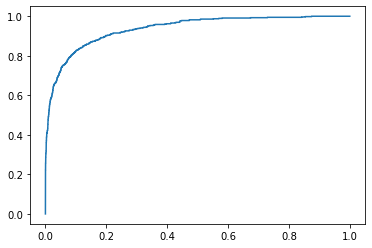

In [12]:
fpr, tpr, _ = roc_curve(ytest, pred_test_prob[:,1])
auc = round(roc_auc_score(ytest, pred_test_prob[:,1]), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

<function matplotlib.pyplot.show(close=None, block=None)>

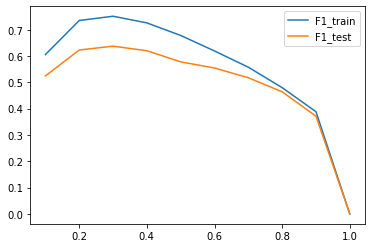

In [13]:
#f1 score is too low, try to change the threshold
model = LogisticRegression(max_iter=500)

model.fit(Xtrain, ytrain)

threshold_list = np.arange(0.1,1.1,0.1)

f1_train = []
f1_test = []

for threshold in threshold_list:   
    pred_train = model.predict_proba(Xtrain)[:,1] >= threshold
    pred_test = model.predict_proba(Xtest)[:,1] >= threshold
    
    f1_train.append(f1_score(ytrain, pred_train))
    f1_test.append(f1_score(ytest, pred_test))


plt.plot(threshold_list, f1_train, label = 'F1_train')
plt.plot(threshold_list, f1_test, label = 'F1_test')
plt.legend()
plt.show

The threshold would be 0.3 for f1 score

Train F1-Score: 0.7510229776518728
Test F1-Score: 0.6373411534701858
Train AUC: 0.9746752008257416
Test AUC: 0.9365273593006767


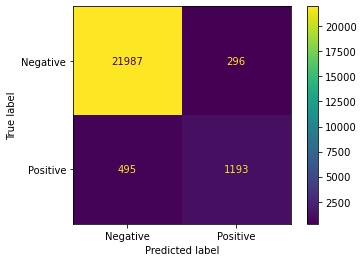

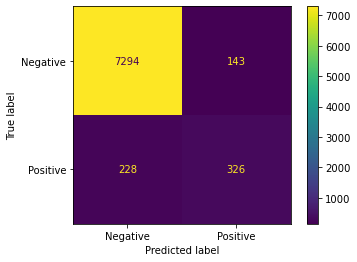

In [14]:
model = LogisticRegression(max_iter=500)

model.fit(Xtrain, ytrain)

pred_train = model.predict_proba(Xtrain)[:,1] >= 0.3
pred_test = model.predict_proba(Xtest)[:,1] >= 0.3

cm_train = confusion_matrix(ytrain, pred_train)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = ['Negative','Positive'])
cm_display_train.plot()

cm_test = confusion_matrix(ytest, pred_test)
cm_display_test = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['Negative','Positive'])
cm_display_test.plot()

#f1
logit_train_f1 = f1_score(ytrain, pred_train)
logit_test_f1 = f1_score(ytest, pred_test)
print('Train F1-Score:', logit_train_f1)
print('Test F1-Score:', logit_test_f1)

#AUC
pred_train_prob = model.predict_proba(Xtrain)
pred_test_prob = model.predict_proba(Xtest)

logit_train_auc = roc_auc_score(ytrain, pred_train_prob[:,1])
logit_test_auc = roc_auc_score(ytest, pred_test_prob[:,1])
print('Train AUC:', logit_train_auc)
print('Test AUC:', logit_test_auc)

## CNN

In [15]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras import regularizers

In [16]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [17]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

tokenizer.fit_on_texts(inputs_train)

sequences_train = tokenizer.texts_to_sequences(inputs_train)
sequences_test = tokenizer.texts_to_sequences(inputs_test)

In [18]:
#get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 38269 unique tokens.


In [19]:
# pad sequences so that we get a N*T matrix

data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

#get sequence length
T = data_train.shape[1]
print(T)

Shape of data train tensor: (23971, 39)
39


In [20]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (7991, 39)


In [21]:
data_train.shape, ytrain.shape

((23971, 39), (23971,))

In [22]:
#chossing embedding dimensionality
D = 20
K = 2

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i) 
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)  

model = Model(i,x)

2022-06-30 12:20:49.134923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 20)            765400    
                                                                 
 conv1d (Conv1D)             (None, 37, 32)            1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                         

In [24]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [25]:
print('Training model...')
r = model.fit(
    data_train, 
    ytrain, 
    epochs=20,
    validation_data=(data_test, ytest)
    )

Training model...
Epoch 1/20
750/750 [==============================] - 14s 17ms/step - loss: 0.2322 - accuracy: 0.9287 - val_loss: 0.1899 - val_accuracy: 0.9307
Epoch 2/20
750/750 [==============================] - 12s 16ms/step - loss: 0.1626 - accuracy: 0.9452 - val_loss: 0.1784 - val_accuracy: 0.9429
Epoch 3/20
750/750 [==============================] - 11s 14ms/step - loss: 0.1306 - accuracy: 0.9553 - val_loss: 0.1815 - val_accuracy: 0.9448
Epoch 4/20
750/750 [==============================] - 11s 14ms/step - loss: 0.1042 - accuracy: 0.9656 - val_loss: 0.2103 - val_accuracy: 0.9454
Epoch 5/20
750/750 [==============================] - 9s 13ms/step - loss: 0.0823 - accuracy: 0.9738 - val_loss: 0.2438 - val_accuracy: 0.9443
Epoch 6/20
750/750 [==============================] - 10s 13ms/step - loss: 0.0678 - accuracy: 0.9791 - val_loss: 0.2952 - val_accuracy: 0.9426
Epoch 7/20
750/750 [==============================] - 13s 18ms/step - loss: 0.0593 - accuracy: 0.9824 - val_loss: 0.318

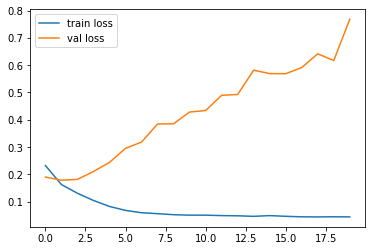

In [26]:
#plot loss per iteration
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

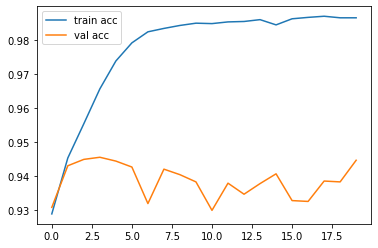

In [27]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();

#### Overfitting -> Regularization

In [28]:
#adding l2 normalization
#reduce one layer
#adding dropout
D = 20
K = 2

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i) 
x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l2(l=0.01))(x)
#x = MaxPooling1D(3)(x)
#x = Conv1D(128, 3, activation = 'relu', kernel_regularizer=regularizers.l2(l=0.01))(x)
x = GlobalMaxPooling1D()(x)
#x = Dropout(0.5)
x = Dense(K)(x)  

model = Model(i,x)

In [31]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = 'adam',
    metrics = ['accuracy']
    )
print('Training model...')
r2 = model.fit(
    data_train, 
    ytrain, 
    epochs=20,
    validation_data=(data_test, ytest)
    )

Training model...
Epoch 1/20
750/750 [==============================] - 12s 15ms/step - loss: 0.0367 - accuracy: 0.9904 - val_loss: 0.4000 - val_accuracy: 0.9451
Epoch 2/20
750/750 [==============================] - 10s 13ms/step - loss: 0.0321 - accuracy: 0.9920 - val_loss: 0.3932 - val_accuracy: 0.9403
Epoch 3/20
750/750 [==============================] - 11s 15ms/step - loss: 0.0311 - accuracy: 0.9922 - val_loss: 0.3816 - val_accuracy: 0.9379
Epoch 4/20
750/750 [==============================] - 10s 14ms/step - loss: 0.0302 - accuracy: 0.9927 - val_loss: 0.4554 - val_accuracy: 0.9402
Epoch 5/20
750/750 [==============================] - 11s 15ms/step - loss: 0.0284 - accuracy: 0.9931 - val_loss: 0.3948 - val_accuracy: 0.9346
Epoch 6/20
750/750 [==============================] - 12s 16ms/step - loss: 0.0275 - accuracy: 0.9936 - val_loss: 0.4449 - val_accuracy: 0.9334
Epoch 7/20
750/750 [==============================] - 13s 17ms/step - loss: 0.0273 - accuracy: 0.9936 - val_loss: 0.49

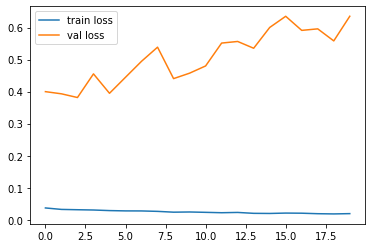

In [32]:
#with 2 layer and -2 normalization
plt.plot(r2.history['loss'], label = 'train loss')
plt.plot(r2.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();